In [5]:
import pandas as pd
import numpy as np
from collections import Counter
from re import M

pd.set_option("display.max_columns", None)

In [391]:
# Get approximate number of available training examples (COINS data)

swan = pd.read_csv('data/SWAN.csv', engine='python')
whodas = pd.read_csv('data/WHODAS.csv', engine='python')
diagnoses = pd.read_csv('data/assessment_data/9994_ConsensusDx_20211130.csv', engine='python')
diagnoses = diagnoses.rename(columns = lambda column: column.split(",")[-1])
# Ignore the extra extra header and drop duplicates
swan = swan.iloc[1:, :].drop_duplicates()
whodas = whodas.iloc[1:, :].drop_duplicates()
diagnoses = diagnoses.iloc[1:, :].drop_duplicates()

In [7]:
merged_swan_diag = pd.merge(swan, diagnoses, on="EID")
merged_whodas_diag = pd.merge(whodas, diagnoses, on="EID")

In [8]:
merged_swan_diag["EID"].count()

3479

In [9]:
merged_swan_diag["EID"].nunique()

3144

In [10]:
merged_whodas_diag["EID"].count()

2695

In [11]:
merged_whodas_diag["EID"].nunique()

2528

In [12]:
# Remove missing diagnoses

merged_whodas_diag = merged_whodas_diag.drop(merged_whodas_diag[
    (merged_whodas_diag["DX_01"] == "No Diagnosis Given: Incomplete Eval")].index)

merged_whodas_diag["EID"].nunique()

2317

In [13]:
# Diagnosis counts (any position)

pd.set_option('display.max_rows', None) 
diag_colunms = ["DX_01", "DX_02", "DX_03", "DX_04", "DX_05", "DX_06", "DX_07", "DX_08", "DX_09", "DX_10"]
merged_whodas_diag[diag_colunms].apply(pd.Series.value_counts).sum(numeric_only=True, axis=1).sort_values(ascending=False)

ADHD-Combined Type                                                             712.0
ADHD-Inattentive Type                                                          706.0
Specific Learning Disorder with Impairment in Reading                          448.0
Generalized Anxiety Disorder                                                   400.0
Autism Spectrum Disorder                                                       390.0
Oppositional Defiant Disorder                                                  330.0
Specific Phobia                                                                305.0
Language Disorder                                                              288.0
Social Anxiety (Social Phobia)                                                 281.0
Specific Learning Disorder with Impairment in Mathematics                      217.0
Enuresis                                                                       213.0
Major Depressive Disorder                                        

In [15]:
# Diagnosis combinations counts

def clean_diag_list(row):
    row_without_duplicates = list({x for x in set(row) if x==x})
    row_without_duplicates.sort()
    return str(row_without_duplicates)

list_of_diagnosis_sets = list(map(clean_diag_list, merged_whodas_diag[diag_colunms].to_numpy()))

counter = Counter(list_of_diagnosis_sets).most_common()
diag_combination_counter_df = pd.DataFrame.from_dict(counter)

pd.set_option('display.max_colwidth', None)

diag_combination_counter_df[diag_combination_counter_df[1] > 1].head(10000) # only display combinations that occure more than once

,0,1
0,['No Diagnosis Given'],164
1,['ADHD-Inattentive Type'],154
2,['ADHD-Combined Type'],141
3,['Specific Learning Disorder with Impairment in Reading'],54
4,"['ADHD-Combined Type', 'Oppositional Defiant Disorder']",43
5,['Major Depressive Disorder'],36
6,['Other Specified Attention-Deficit/Hyperactivity Disorder'],35
7,"['ADHD-Combined Type', 'Autism Spectrum Disorder']",34
8,"['ADHD-Inattentive Type', 'Autism Spectrum Disorder']",32
9,['Generalized Anxiety Disorder'],25


In [16]:
pd.set_option('display.max_rows', 20) 

## Explore questionnaire distribution
### LORIS data

In [17]:
# LORIS saved query (all data)

full = pd.read_csv("data/all1.csv", dtype=object)

In [18]:
# Check which questionnaires are in the rows with unserscores (NDARZZ007YMP_1, NDARAA075AMK_Visit_1)

rows_with_underscore_in_id = full[full["Identifiers"].str.contains("_")]
non_empty_columns = rows_with_underscore_in_id.columns[
    ~rows_with_underscore_in_id.isin(["."]).all()].tolist()
non_empty_questionnaires_in_underscore = set([x.split(",")[0] for x in non_empty_columns])
non_empty_questionnaires_in_underscore

{'DailyMeds', 'Identifiers', 'TRF', 'TRF_P', 'TRF_Pre'}

In [19]:
# Drop rows with underscores and the questionnaires present in rows with underscores 

non_empty_questionnaires_in_underscore.remove("Identifiers")
main = full[~full["Identifiers"].str.contains("_")]
len(main.columns)

7284

In [20]:
filtered_main = main
for questionnaire in non_empty_questionnaires_in_underscore:
    filtered_main = filtered_main.drop(filtered_main.filter(regex=(questionnaire+",")), axis=1)
    len(filtered_main.columns)

In [21]:
# Exract ID

filtered_main["ID"] = filtered_main["Identifiers"].str.split(',').str[0].str.split('_').str[0]

# Drop IDs with quotes around them (duplicates)

filtered_main[filtered_main["ID"].str.contains("'")]
filtered_main = filtered_main.drop(filtered_main[filtered_main["ID"].str.contains("'")].index)

In [22]:
filtered_main["Identifiers"].count()

4147

More unique IDs than in release notes

In [23]:
# filtered_main["Identifiers"].value_counts() # large output

In [24]:
filtered_main["ID"].count()

4147

In [25]:
filtered_main["ID"].nunique()

4147

In [26]:
# Replace . with NaN

filtered_main = filtered_main.replace(".", np.nan)

In [27]:
# How many people answered all questionnaires (Data_entry value for every questionnaire is not empty)

data_entry_columns = filtered_main.filter(regex=(",Data_entry"))
data_entry_columns.dropna(how = 'any')

,"ACE,Data_entry","APQ_P,Data_entry","APQ_SR,Data_entry","ARI_P,Data_entry","ARI_S,Data_entry","ASR,Data_entry","ASSQ,Data_entry","Audit,Data_entry","BIA,Data_entry","Barratt,Data_entry","Basic_Demos,Data_entry","C3SR,Data_entry","CAARS,Data_entry","CBCL,Data_entry","CBCL_Pre,Data_entry","CCSC,Data_entry","CDI_P,Data_entry","CDI_SR,Data_entry","CELF,Data_entry","CELF5_Meta,Data_entry","CELF_Full_5to8,Data_entry","CELF_Full_9to21,Data_entry","CELF_Meta,Data_entry","CGAS,Data_entry","CIS_P,Data_entry","CIS_SR,Data_entry","CPIC,Data_entry","CTOPP,Data_entry","ColorVision,Data_entry","ConsensusDx,Data_entry","DSM5_Dx,Data_entry","DTS,Data_entry","Diagnosis_ClinicianConsensus,Data_entry","DigitSpan,Data_entry","DrugScreen,Data_entry","EEG_Track,Data_entry","EHQ,Data_entry","ESPAD,Data_entry","ESWAN,Data_entry","EVT,Data_entry","FFQ,Data_entry","FGC,Data_entry","FSQ,Data_entry","FTND,Data_entry","FTQA,Data_entry","GFTA,Data_entry","IAT,Data_entry","ICU_P,Data_entry","KBIT,Data_entry","MFQ_P,Data_entry","MFQ_SR,Data_entry","MRI_Track,Data_entry","NIDA,Data_entry","NIH5,Data_entry","NIH7,Data_entry","NLES_P,Data_entry","NLES_SR,Data_entry","PAQ_A,Data_entry","PAQ_C,Data_entry","PBQ,Data_entry","PCIAT,Data_entry","PPS,Data_entry","PPVT,Data_entry","PSI,Data_entry","Pegboard,Data_entry","PhenX_Neighborhood,Data_entry","PhenX_SchoolRisk,Data_entry","Physical,Data_entry","PreInt_Demos_Fam,Data_entry","PreInt_Demos_Home,Data_entry","PreInt_DevHx,Data_entry","PreInt_EduHx,Data_entry","PreInt_FamHx,Data_entry","PreInt_FamHx_RDC,Data_entry","PreInt_Lang,Data_entry","PreInt_TxHx,Data_entry","Pregnancy,Data_entry","Quotient,Data_entry","Quotient_Ext,Data_entry","RANRAS,Data_entry","RBS,Data_entry","SAS,Data_entry","SCARED_P,Data_entry","SCARED_SR,Data_entry","SCQ,Data_entry","SDQ,Data_entry","SDS,Data_entry","SRS,Data_entry","SRS_Pre,Data_entry","STAI,Data_entry","SWAN,Data_entry","SympChck,Data_entry","TOWRE,Data_entry","Tanner,Data_entry","Vineland,Data_entry","WAIS,Data_entry","WASI,Data_entry","WHODAS_P,Data_entry","WHODAS_SR,Data_entry","WIAT,Data_entry","WISC,Data_entry","YFAS,Data_entry","YFAS_C,Data_entry","YSR,Data_entry"


In [28]:
# Get questionnaires most people answered

pd.set_option('display.max_rows', None)
questionnaire_answer_counts = data_entry_columns.count().sort_values(ascending=False).to_frame()
questionnaire_answer_counts["Ratio"] = questionnaire_answer_counts[0]/filtered_main["ID"].nunique()*100
questionnaire_answer_counts

,0,Ratio
"Basic_Demos,Data_entry",4145,99.951772
"Diagnosis_ClinicianConsensus,Data_entry",4106,99.011333
"PreInt_EduHx,Data_entry",4070,98.143236
"PreInt_DevHx,Data_entry",4066,98.046781
"WIAT,Data_entry",4061,97.926212
"PreInt_TxHx,Data_entry",4056,97.805643
"ColorVision,Data_entry",4035,97.299252
"Pegboard,Data_entry",4025,97.058114
"CELF,Data_entry",3973,95.804196
"FGC,Data_entry",3973,95.804196


In [29]:
filtered_main[filtered_main["ASR,Data_entry"].notna()]["ID"] # Check that all IDs seem valid 

0                   
3       NDARAA306NT2
70      NDARAK078LMR
96      NDARAP457WB5
115     NDARAT581NDH
203     NDARBF851NH6
385     NDARCP292KPA
399     NDARCT889DMB
414     NDARCV154DB9
506     NDARDJ970ELG
629     NDAREF662XZT
660     NDAREL410HHK
680     NDAREP505XAD
700     NDAREV342ABE
740     NDARFA737TG6
746     NDARFA867YGW
800     NDARFJ372JDJ
821     NDARFM948RTJ
822     NDARFN214WHQ
863     NDARFV061AR5
891     NDARFY628PGF
908     NDARGB060TAM
922     NDARGC471KD1
1063    NDARHB803UT9
1140    NDARHP841RMR
1195    NDARHZ413DZL
1208    NDARJA830BYV
1248    NDARJG740PM8
1283    NDARJK154PF5
1404    NDARKF899ZUB
1410    NDARKG697CEW
1429    NDARKK732JW3
1456    NDARKN520GGD
1457    NDARKN633WZA
1502    NDARKZ031NJZ
1522    NDARLB657MJV
1794    NDARMV319CAT
1846    NDARNB738TM9
2016    NDARPB044UXA
2034    NDARPE424GZZ
2071    NDARPJ151ERK
2088    NDARPL501ZUU
2097    NDARPN886HH9
2140    NDARPY478YM0
2210    NDARRK545WNM
2259    NDARRU499DP2
2299    NDARRY126FA5
2347    NDART

In [30]:
# List of top mental health quetsionnaires and output variables (consensus diagnosis and impairment)

top_mh_assessments = ['Diagnosis_ClinicianConsensus', 'ARI_S', 'SympChck', 'SCQ', 'ASSQ', 'SDQ', 'ARI_P', 'SWAN', 'SRS', 'CBCL', 'NLES_P', 
'SCARED_P', 'ICU_P', 'PCIAT', 'DTS', 'ESWAN', 'MFQ_P', 'YFAS_C', 'WHODAS_P', 'SDS', 'CIS_P', 'SAS', 'WHODAS_SR', 
'CIS_SR', 'CGAS', 'RBS', 'C3SR', 'SCARED_SR', 'MFQ_SR', 'CCSC', 'YSR', 'CDI_P', 'CDI_SR', 'YFAS', 
'CBCL_Pre', 'SRS_Pre', 'ASR', 'CAARS', 'STAI']

In [31]:
# get number of people who took all top 1, top 2, top 3, etc. popular assessments

cumul_number_of_examples_list = []
for i in range(1, len(top_mh_assessments)+1):
    columns = [x+",Data_entry" for x in top_mh_assessments[0:i]]
    cumul_number_of_examples = data_entry_columns[columns].notnull().all(axis=1).sum()
    print([x.split(",")[0] for x in columns], ": ", cumul_number_of_examples)
    cumul_number_of_examples_list.append(cumul_number_of_examples)

['Diagnosis_ClinicianConsensus'] :  4106
['Diagnosis_ClinicianConsensus', 'ARI_S'] :  3720
['Diagnosis_ClinicianConsensus', 'ARI_S', 'SympChck'] :  3507
['Diagnosis_ClinicianConsensus', 'ARI_S', 'SympChck', 'SCQ'] :  3489
['Diagnosis_ClinicianConsensus', 'ARI_S', 'SympChck', 'SCQ', 'ASSQ'] :  3458
['Diagnosis_ClinicianConsensus', 'ARI_S', 'SympChck', 'SCQ', 'ASSQ', 'SDQ'] :  3405
['Diagnosis_ClinicianConsensus', 'ARI_S', 'SympChck', 'SCQ', 'ASSQ', 'SDQ', 'ARI_P'] :  3386
['Diagnosis_ClinicianConsensus', 'ARI_S', 'SympChck', 'SCQ', 'ASSQ', 'SDQ', 'ARI_P', 'SWAN'] :  3312
['Diagnosis_ClinicianConsensus', 'ARI_S', 'SympChck', 'SCQ', 'ASSQ', 'SDQ', 'ARI_P', 'SWAN', 'SRS'] :  3235
['Diagnosis_ClinicianConsensus', 'ARI_S', 'SympChck', 'SCQ', 'ASSQ', 'SDQ', 'ARI_P', 'SWAN', 'SRS', 'CBCL'] :  3233
['Diagnosis_ClinicianConsensus', 'ARI_S', 'SympChck', 'SCQ', 'ASSQ', 'SDQ', 'ARI_P', 'SWAN', 'SRS', 'CBCL', 'NLES_P'] :  3044
['Diagnosis_ClinicianConsensus', 'ARI_S', 'SympChck', 'SCQ', 'ASSQ', 'SDQ

### COINS data

In [390]:
# Read relevant coins data (Consensus diagnosis + Questionnnaire Measures of Emotional and Cognitive Status from Assessment_List_Jan2019) + Basic demos and Baratt
# exclude TRF and TRF_Pre for now, to see what to do with multiple entries per person

assessments = ['ConsensusDx', 'Basic_Demos', 'Barratt', 'ASR', 'YSR', 'MFQ_SR', 'SCARED_SR', 'C3SR', 'ARI_S', 'CSSRS', 'CIS_SR', 'WHODAS_SR', 
'ICU_SR', 'PANAS', 'CBCL', 'CBCL_Pre', 'MFQ_P', 'SCARED_P', 'ESWAN', 'SWAN', 'ASSQ', 'SCQ', 'CIS_P', 
'SAS', 'WHODAS_P', 'SDQ', 'RBS', 'SRS', 'SRS_Pre', 'ARI_P', 'ICU_P', 'SympChck']

# Read all assessment files into dataframes

coins_file_names = ['9994_' + x + '_20211130.csv' for x in assessments]

all_coins_dfs = []
for file_name in coins_file_names:
    temp_df = pd.read_csv('data/assessment_data/' + file_name, header=1, engine='python')
    all_coins_dfs.append(temp_df)

In [337]:
# Check that no assessments have duplicated IDs (will aggregate assessment by ID by taking the first non-null value)

for df in all_coins_dfs:
    print(df.columns[4], ": ", df["ID"].count() == df["ID"].nunique())

ConsensusDx_001 :  False
BASIC1_001 :  True
BARRATT1_001 :  True
ASRHBN_001 :  True
YSR1_001 :  True
MFQSR_001 :  True
SCAREDSR_001 :  True
C3SR_001 :  True
ARIS1_001 :  True
CSSRS_HBN_001 :  True
CISSR1_001 :  True
WHODASSR_001 :  True
ICUSR_001 :  True
PANAS_HBN_001 :  True
CBCLHBN_001 :  True
CBCL_Pre_001 :  True
MFQP_001 :  True
SCAREDP1_001 :  True
ESWAN_001 :  True
SWAN1_001 :  True
ASSQ1_001 :  True
SCQHBN_001 :  True
CISP_001 :  True
SAS0_001 :  True
WHODASP_001 :  True
SDQHBN_001 :  True
RBS0_001 :  True
SRSHBN_001 :  True
SRSPRE_001 :  True
ARIP1_001 :  True
ICUPHBN_001 :  True
CSC_001 :  True


Exclude 'TRF', 'TRF_Pre' from the assessment list for now, investigate ConsensusDx

In [338]:
# Investigate duplicated IDs in ConsensusDx

all_coins_dfs[0]["ID"].count()

6182

In [339]:
all_coins_dfs[0]["ID"].nunique()

3617

In [340]:
all_coins_dfs[0] = all_coins_dfs[0].drop_duplicates()
all_coins_dfs[0]["ID"].count()

3975

In [341]:
# all_coins_dfs[0][all_coins_dfs[0].duplicated(['ID'], keep=False)][0:10] # output suppressed for privacy

Seems like the second line in each pair has more values, will take second line as truth, to investigate further

In [342]:
all_coins_dfs[0] = all_coins_dfs[0].groupby("ID").last().reset_index()
all_coins_dfs[0]["ID"].count()

3617

In [343]:
# Concatenate all assessments

all_coins = pd.concat(all_coins_dfs)
del all_coins_dfs

all_coins.count()[:10]

ID                 79387
SUB_TYPE           79387
VISIT              79387
DAY_LAG            79387
ConsensusDx_001     3617
ConsensusDx_002     3617
ConsensusDx_003     3617
ConsensusDx_004     3617
ConsensusDx_005     3617
ConsensusDx_006     3617
dtype: int64

In [344]:
all_coins["ID"].nunique()

3633

In [345]:
# Group assessements by person

grouped_coins = all_coins.groupby(by=["ID", "SUB_TYPE", "VISIT", "DAY_LAG"]).first()

In [346]:
pd.set_option('display.max_rows', 100) 
grouped_coins = grouped_coins.reset_index()
grouped_coins.count()

ID                 3633
SUB_TYPE           3633
VISIT              3633
DAY_LAG            3633
ConsensusDx_001    3617
                   ... 
CSC_129            3241
CSC_130            3253
CSC_131            3249
CSC_132            3248
CSC_133            3248
Length: 1909, dtype: int64

In [347]:
# Test grouping on a small subset

ASR = pd.read_csv('data/test/' + coins_file_names[3], header=1)
YSR = pd.read_csv('data/test/' + coins_file_names[4], header=1)
MFQ = pd.read_csv('data/test/' + coins_file_names[5], header=1)
ASR_YSR_MFQ_appended = pd.concat([ASR, YSR, MFQ])

In [348]:
grouped_test = ASR_YSR_MFQ_appended.groupby(by=["ID", "SUB_TYPE", "VISIT", "DAY_LAG"])
# grouped_test.apply(display) # output suppressed for privacy

In [349]:
agg_test = grouped_test.first() 
# agg_test # output suppressed for privacy

In [350]:
# Get questionnaires most people answered

pd.set_option('display.max_rows', None)
assessment_column_names = grouped_coins.columns[grouped_coins.columns.str.contains("_001")]
total_participants = grouped_coins["ID"].nunique()
coins_questionnaire_answer_counts = grouped_coins[assessment_column_names].count().sort_values(ascending=False).to_frame()
coins_questionnaire_answer_counts["Ratio"] = coins_questionnaire_answer_counts[0]/total_participants*100
coins_questionnaire_answer_counts

,0,Ratio
BASIC1_001,3633,100.000000
ConsensusDx_001,3617,99.559593
ARIS1_001,3278,90.228461
CSC_001,3265,89.870630
SCQHBN_001,3258,89.677952
BARRATT1_001,3252,89.512799
ASSQ1_001,3235,89.044867
SDQHBN_001,3197,87.998899
ARIP1_001,3190,87.806221
SWAN1_001,3155,86.842830


In [351]:
# Remove incomplete Dx

grouped_coins = grouped_coins[grouped_coins["ConsensusDx_010"] != "No Diagnosis Given: Incomplete Eval"]
grouped_coins["ConsensusDx_010"].value_counts()[:10]

ADHD-Combined Type                                          666
ADHD-Inattentive Type                                       588
No Diagnosis Given                                          308
Autism Spectrum Disorder                                    272
Specific Learning Disorder with Impairment in Reading       202
Generalized Anxiety Disorder                                153
Other Specified Attention-Deficit/Hyperactivity Disorder     99
Social Anxiety (Social Phobia)                               93
ADHD-Hyperactive/Impulsive Type                              93
Major Depressive Disorder                                    91
Name: ConsensusDx_010, dtype: int64

In [352]:
# Re-calculate questionnaires most people answered without incomplete diagnoses

coins_questionnaire_answer_counts = grouped_coins[assessment_column_names].count().sort_values(ascending=False).to_frame()
coins_questionnaire_answer_counts["Ratio"] = coins_questionnaire_answer_counts[0]/total_participants*100
coins_questionnaire_answer_counts

,0,Ratio
BASIC1_001,3180,87.530966
ConsensusDx_001,3164,87.090559
SCQHBN_001,3127,86.072117
CSC_001,3124,85.989540
BARRATT1_001,3124,85.989540
ASSQ1_001,3123,85.962015
ARIP1_001,3087,84.971098
SDQHBN_001,3077,84.695844
SWAN1_001,3046,83.842554
ARIS1_001,3027,83.319571


In [353]:
# Get number of people who took all top 1, top 2, top 3, etc. popular assessments

assessments_in_order = coins_questionnaire_answer_counts.index.to_list() # extract assessemnts in order of popularity
cumul_number_of_examples_list = []
for i in range(1, len(assessments_in_order)+1):
    columns = assessments_in_order[0:i] # top i assessments
    cumul_number_of_examples = grouped_coins[columns].notnull().all(axis=1).sum()
    print(columns, ": ", cumul_number_of_examples)
    cumul_number_of_examples_list.append(cumul_number_of_examples)

['BASIC1_001'] :  3180
['BASIC1_001', 'ConsensusDx_001'] :  3164
['BASIC1_001', 'ConsensusDx_001', 'SCQHBN_001'] :  3118
['BASIC1_001', 'ConsensusDx_001', 'SCQHBN_001', 'CSC_001'] :  3109
['BASIC1_001', 'ConsensusDx_001', 'SCQHBN_001', 'CSC_001', 'BARRATT1_001'] :  3077
['BASIC1_001', 'ConsensusDx_001', 'SCQHBN_001', 'CSC_001', 'BARRATT1_001', 'ASSQ1_001'] :  3068
['BASIC1_001', 'ConsensusDx_001', 'SCQHBN_001', 'CSC_001', 'BARRATT1_001', 'ASSQ1_001', 'ARIP1_001'] :  3031
['BASIC1_001', 'ConsensusDx_001', 'SCQHBN_001', 'CSC_001', 'BARRATT1_001', 'ASSQ1_001', 'ARIP1_001', 'SDQHBN_001'] :  2987
['BASIC1_001', 'ConsensusDx_001', 'SCQHBN_001', 'CSC_001', 'BARRATT1_001', 'ASSQ1_001', 'ARIP1_001', 'SDQHBN_001', 'SWAN1_001'] :  2912
['BASIC1_001', 'ConsensusDx_001', 'SCQHBN_001', 'CSC_001', 'BARRATT1_001', 'ASSQ1_001', 'ARIP1_001', 'SDQHBN_001', 'SWAN1_001', 'ARIS1_001'] :  2809
['BASIC1_001', 'ConsensusDx_001', 'SCQHBN_001', 'CSC_001', 'BARRATT1_001', 'ASSQ1_001', 'ARIP1_001', 'SDQHBN_001', '

In [354]:
# List of most popular assessments until the first one with an age restriction
first_columns_until_SCARED = [x for x in assessments_in_order[:assessments_in_order.index("SCAREDSR_001")]]
first_columns_until_SCARED

['BASIC1_001',
 'ConsensusDx_001',
 'SCQHBN_001',
 'CSC_001',
 'BARRATT1_001',
 'ASSQ1_001',
 'ARIP1_001',
 'SDQHBN_001',
 'SWAN1_001',
 'ARIS1_001',
 'SRSHBN_001',
 'CBCLHBN_001',
 'SCAREDP1_001',
 'ICUPHBN_001',
 'ESWAN_001',
 'MFQP_001',
 'WHODASP_001',
 'CISP_001',
 'SAS0_001',
 'RBS0_001',
 'WHODASSR_001',
 'CISSR1_001']

In [397]:
# Get only people who took the most popular assessments until the first one with an age restriction (SCARED)
columns_until_SCARED = []
assessments_until_SCARED = [x.split("_")[0] for x in first_columns_until_SCARED]
for assessment in assessments_until_SCARED:
    columns = [column for column in grouped_coins.columns if(assessment in column)]
    columns_until_SCARED.extend(columns)
    
data_up_to_SCARED = grouped_coins.loc[grouped_coins[first_columns_until_SCARED].dropna(how="any").index][columns_until_SCARED+["ID"]]

# Investigate missing values (up to SCARED)
missing_report_up_to_SCARED = data_up_to_SCARED.isna().sum().to_frame(name="Amount missing")
missing_report_up_to_SCARED["Persentage missing"] = missing_report_up_to_SCARED["Amount missing"]/data_up_to_SCARED["ID"].nunique() * 100
missing_report_up_to_SCARED[
    (~missing_report_up_to_SCARED.index.str.contains("ConsensusDx")) # don't print missing data in dx because it's expected
    &
    (missing_report_up_to_SCARED["Persentage missing"] > 1)
].sort_values(ascending=False, by="Amount missing").style.format(precision=2)

,Amount missing,Persentage missing
ESWAN_057,2043,100.00
ESWAN_059,2043,100.00
ESWAN_058,2043,100.00
SRSHBN_053,1406,68.82
CBCLHBN_129,1195,58.49
CBCLHBN_128,1074,52.57
CBCLHBN_127,884,43.27
BARRATT1_012,304,14.88
BARRATT1_009,251,12.29
SDQHBN_034,209,10.23


<AxesSubplot:>

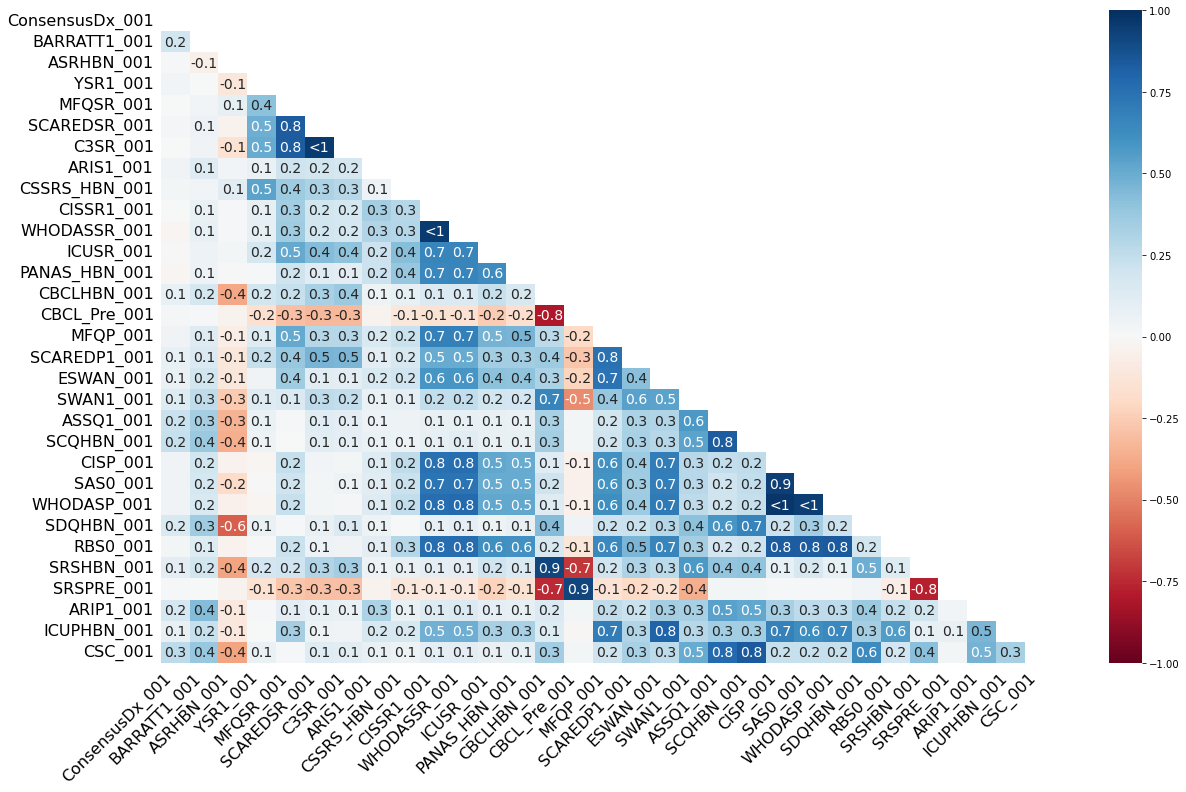

In [356]:
# Check if missing columns are dependent on each other

import missingno as msno
msno.heatmap(grouped_coins[assessment_column_names])

In [412]:
# Check if missing columns are dependent on demographics and barratt

data_for_na_report = grouped_coins.copy()
data_for_na_report[assessment_column_names] = data_for_na_report[assessment_column_names].notnull().astype('int')
data_for_na_report["ASRHBN_001"].value_counts()

corr_matrix = data_for_na_report[list(assessment_column_names) + ["BASIC1_004", "BASIC1_005"]].corr().drop(labels=["BASIC1_004", "BASIC1_005"])
corr_matrix[["BASIC1_004", "BASIC1_005"]].style.background_gradient(cmap='coolwarm', vmin=-0.8, vmax=0.8).format(precision=2)

,BASIC1_004,BASIC1_005
ConsensusDx_001,0.02,0.03
BASIC1_001,nan,nan
BARRATT1_001,0.01,-0.04
ASRHBN_001,0.04,0.42
YSR1_001,0.02,0.70
MFQSR_001,0.02,0.56
SCAREDSR_001,0.04,0.59
C3SR_001,0.04,0.54
ARIS1_001,0.03,0.06
CSSRS_HBN_001,0.00,0.49


Besides expected results (e.g. "_Pre" assessements missing for older kids): 
* **CSSRS** - more missing assessments for yournger kids
* **SDQ**, **CSC** - more missing assessments for older kids

In [389]:
corr_matrix = data_for_na_report[list(assessment_column_names) + ["BARRATT1_008", "BARRATT1_009", "BARRATT1_010", 
                                                       "BARRATT1_011", "BARRATT1_012", "BARRATT1_013", "BARRATT1_014"]].corr().drop(labels=["BARRATT1_008", 
                                                                                                                                            "BARRATT1_009", "BARRATT1_010", 
                                                                                                                                            "BARRATT1_011", "BARRATT1_012", 
                                                                                                                                            "BARRATT1_013", "BARRATT1_014"])
corr_matrix[["BARRATT1_008", "BARRATT1_009", "BARRATT1_010",
             "BARRATT1_011", "BARRATT1_012", "BARRATT1_013", "BARRATT1_014"]].style.background_gradient(cmap='coolwarm', vmin=-0.8, vmax=0.8).format(precision=2)


,BARRATT1_008,BARRATT1_009,BARRATT1_010,BARRATT1_011,BARRATT1_012,BARRATT1_013,BARRATT1_014
ConsensusDx_001,-0.02,-0.01,-0.01,-0.03,0.03,-0.01,-0.01
BASIC1_001,nan,nan,nan,nan,nan,nan,nan
BARRATT1_001,nan,nan,nan,nan,nan,nan,nan
ASRHBN_001,-0.03,0.00,-0.03,-0.00,-0.02,-0.01,-0.01
YSR1_001,-0.02,0.00,-0.01,0.03,0.04,0.00,-0.00
MFQSR_001,0.05,0.07,0.07,0.02,0.07,0.04,0.05
SCAREDSR_001,0.01,0.02,0.02,0.02,0.03,-0.00,0.00
C3SR_001,0.00,0.01,0.01,0.01,0.03,-0.01,-0.01
ARIS1_001,0.04,0.03,0.05,0.00,0.04,0.04,0.04
CSSRS_HBN_001,0.05,0.07,0.06,0.04,0.07,0.06,0.06
